# Exploratory data analysis

In [3]:
import pandas as pd
import numpy as np
from os.path import join
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

In [4]:
src = '../data'
dst = '../plots'
fname = 'V5_9_1_coded_V1_clean.csv'
data = pd.read_csv(join(src, fname))

In [5]:
data['action'] = data['action'].apply(lambda x: eval(x) if x == x else np.nan)
data['method'] = data['method'].apply(lambda x: eval(x) if x == x else np.nan)
data['discipline'] = data['discipline'].apply(lambda x: eval(x) if x == x else np.nan)
data['group'] = data['group'].apply(lambda x: eval(x) if x == x else np.nan)
data['geo'] = data['geo'].apply(lambda x: eval(x) if x == x else np.nan)

## Wordcloud from article titles

In [8]:
text = ''
for title in data['Article Title']:
    text += ' '
    text += title
    
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white", colormap=plt.get_cmap('inferno'))
wordcloud = wc.generate(text)

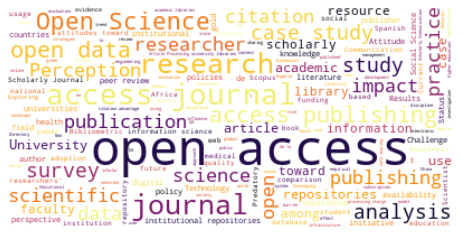

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis('off')
plt.savefig(join(dst, 'title_text_wordcloud.png'), dpi=300)

## Citations over publication year

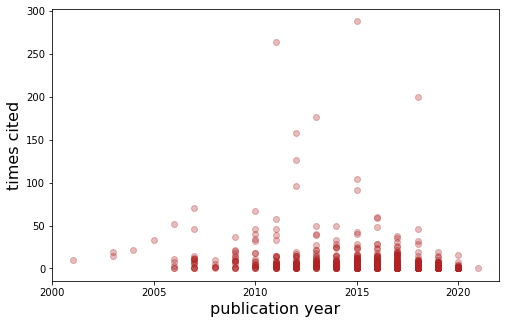

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
cols = ['Publication Year', 'Times Cited, All Databases']
tmp = data[cols].dropna(subset=cols).copy()
tmp = tmp.astype(int)
ax.scatter(tmp['Publication Year'], tmp['Times Cited, All Databases'],
           color='FireBrick', alpha=0.3)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('times cited', fontsize=16)
ax.set_xlabel('publication year', fontsize=16)
plt.savefig(join(dst, 'times_cited_over_publication_year.pdf'))

## Actions over years

In [11]:
disambiguated_action = pd.DataFrame()
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['action'] != row['action']: # NaN check
        continue
    if len(row['action']) == 1:
        disambiguated_action = disambiguated_action.append(
            {'action':row['action'][0],
             'year':int(row['Publication Year']),
             #'N':
             'ID':row['ID']}, ignore_index=True)
    elif len(row['action']) > 1:
        for action in row['action']:
            disambiguated_action = disambiguated_action.append(
                {'action':action,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        print('found one!')

In [12]:
actions = disambiguated_action\
    .groupby(by=['action', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for action in disambiguated_action['action'].unique():
    for year in range(2001, 2022):
        if not actions.index.isin([(action, year)]).any():
            actions.loc[(action, year), :] = 0
            
actions = actions.reset_index()
actions['year'] = actions['year'].astype(int)
actions = actions.sort_values(by=['action', 'year'], ascending=True)

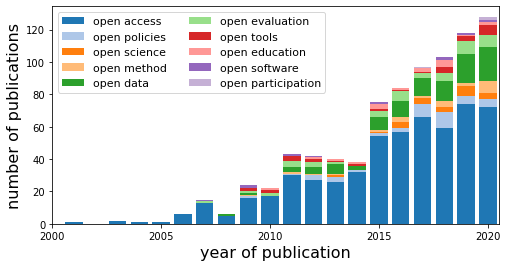

In [13]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, action in enumerate(disambiguated_action['action'].unique()):
    tmp = actions[actions['action'] == action]
    label = 'open {}'.format(action.split('open')[1])
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'actions_over_years.pdf'))

## Methods over years

In [14]:
disambiguated_method = pd.DataFrame()
no_method = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['method'] != row['method']: # NaN check
        continue
    if len(row['method']) == 1:
        disambiguated_method = disambiguated_method.append(
            {'method':row['method'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['action']) > 1:
        for method in row['method']:
            disambiguated_method = disambiguated_method.append(
                {'method':method,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_method = disambiguated_method.append(
            {'method':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_method += 1
print('{} entries without specified method'.format(no_method))

73 entries without specified method


In [15]:
methods = disambiguated_method\
    .groupby(by=['method', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for method in disambiguated_method['method'].unique():
    for year in range(2001, 2022):
        if not methods.index.isin([(method, year)]).any():
            methods.loc[(method, year), :] = 0
            
methods = methods.reset_index()
methods['year'] = methods['year'].astype(int)
methods = methods.sort_values(by=['method', 'year'], ascending=True)

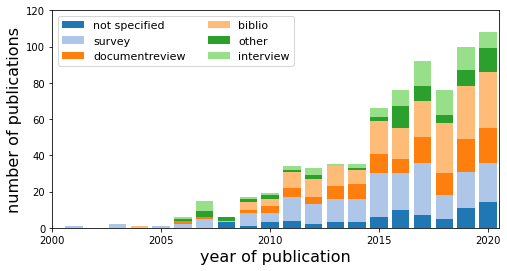

In [16]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, method in enumerate(disambiguated_method['method'].unique()):
    tmp = methods[methods['method'] == method]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=method,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'methods_over_years.pdf'))

## Disciplines over years

In [17]:
disambiguated_discipline = pd.DataFrame()
no_discipline = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['discipline'] != row['discipline']: # NaN check
        continue
    if len(row['discipline']) == 1:
        disambiguated_discipline = disambiguated_discipline.append(
            {'discipline':row['discipline'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['action']) > 1:
        for discipline in row['discipline']:
            disambiguated_discipline = disambiguated_discipline.append(
                {'discipline':discipline,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_discipline = disambiguated_discipline.append(
            {'discipline':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_discipline += 1
print('{} entries without specified discipline'.format(no_discipline))

202 entries without specified discipline


In [18]:
disciplines = disambiguated_discipline\
    .groupby(by=['discipline', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for discipline in disambiguated_discipline['discipline'].unique():
    for year in range(2001, 2022):
        if not disciplines.index.isin([(discipline, year)]).any():
            disciplines.loc[(discipline, year), :] = 0
            
disciplines = disciplines.reset_index()
disciplines['year'] = disciplines['year'].astype(int)
disciplines = disciplines.sort_values(by=['discipline', 'year'], ascending=True)

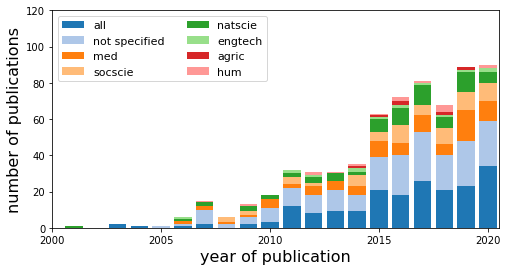

In [19]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['discipline'].unique()):
    tmp = disciplines[disciplines['discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'disciplines_over_years.pdf'));

## Groups over years

In [20]:
disambiguated_group = pd.DataFrame()
no_group = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['group'] != row['group']: # NaN check
        continue
    if len(row['group']) == 1:
        disambiguated_group = disambiguated_group.append(
            {'group':row['group'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['action']) > 1:
        for group in row['group']:
            disambiguated_group = disambiguated_group.append(
                {'group':group,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_group = disambiguated_group.append(
            {'group':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_group += 1
print('{} entries without specified group'.format(no_group))

129 entries without specified group


In [21]:
groups = disambiguated_group\
    .groupby(by=['group', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for group in disambiguated_group['group'].unique():
    for year in range(2001, 2022):
        if not groups.index.isin([(group, year)]).any():
            groups.loc[(group, year), :] = 0
            
groups = groups.reset_index()
groups['year'] = groups['year'].astype(int)
groups = groups.sort_values(by=['group', 'year'], ascending=True)

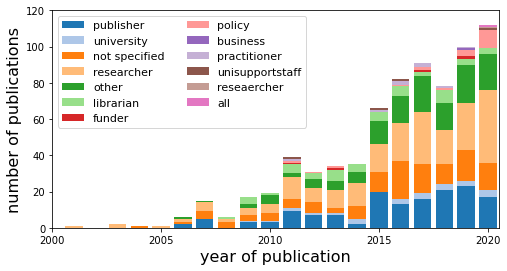

In [22]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['group'].unique()):
    tmp = groups[groups['group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'groups_over_years.pdf'));

## Geo over years

In [23]:
disambiguated_geo = pd.DataFrame()
no_geo = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['geo'] != row['geo']: # NaN check
        continue
    if len(row['geo']) == 1:
        disambiguated_geo = disambiguated_geo.append(
            {'geo':row['geo'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['action']) > 1:
        for geo in row['geo']:
            disambiguated_geo = disambiguated_geo.append(
                {'geo':geo,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_geo = disambiguated_geo.append(
            {'geo':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_geo += 1
print('{} entries without specified geo'.format(no_geo))

45 entries without specified geo


In [24]:
geos = disambiguated_geo\
    .groupby(by=['geo', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for geo in disambiguated_geo['geo'].unique():
    for year in range(2001, 2022):
        if not geos.index.isin([(geo, year)]).any():
            geos.loc[(geo, year), :] = 0
            
geos = geos.reset_index()
geos['year'] = geos['year'].astype(int)
geos = geos.sort_values(by=['geo', 'year'], ascending=True)

In [25]:
disambiguated_geo['geo'].value_counts()[0:15]

all              276
USA               62
not specified     45
GBR               32
ESP               28
IND               25
DEU               18
CHN               15
NGA               13
CAN               12
Europe            11
ITA               11
FRA               10
AUS                9
Latin America      9
Name: geo, dtype: int64

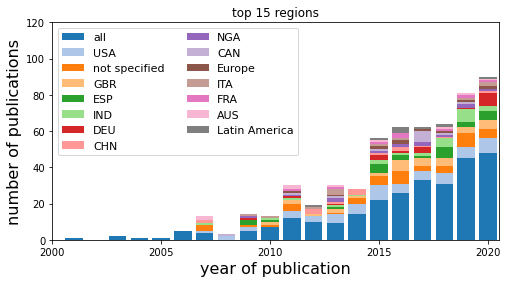

In [26]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['geo'].value_counts()[0:15].index):
    tmp = geos[geos['geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('top 15 regions')
plt.savefig(join(dst, 'geos_over_years.pdf'));

## Compilation plot

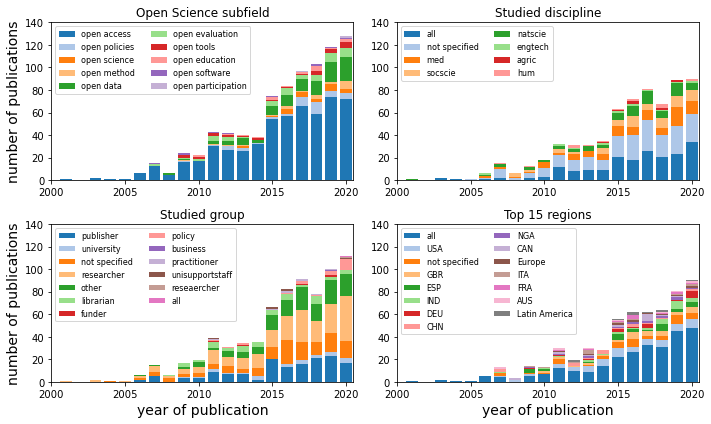

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
ax = axes[0, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, action in enumerate(disambiguated_action['action'].unique()):
    tmp = actions[actions['action'] == action]
    label = 'open {}'.format(action.split('open')[1])
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Open Science subfield')

ax = axes[0, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['discipline'].unique()):
    tmp = disciplines[disciplines['discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=16)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Studied discipline')

ax = axes[1, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['group'].unique()):
    tmp = groups[groups['group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Studied group')

ax = axes[1, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['geo'].value_counts()[0:15].index):
    tmp = geos[geos['geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Top 15 regions')

fig.tight_layout()
plt.savefig(join(dst, 'categories.png'), dpi=300)